In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small,ResNet50,InceptionV3
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import itertools
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train_path='train'
valid_path='valid'
test_path='test'
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),batch_size=20,shuffle=True)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),batch_size=50,shuffle=True)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),batch_size=50,shuffle=True)

Found 11912 images belonging to 2 classes.
Found 2978 images belonging to 2 classes.
Found 3722 images belonging to 2 classes.


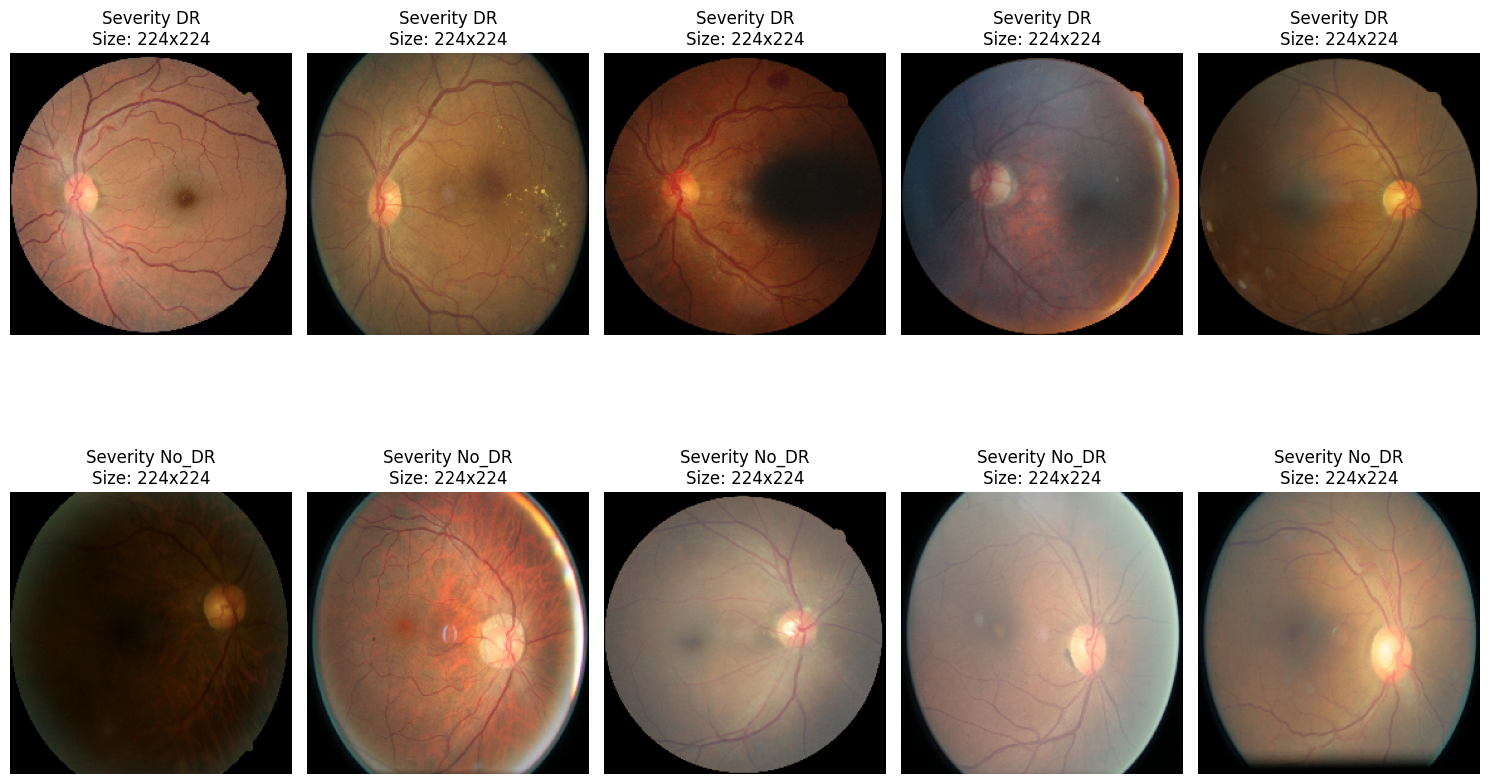

In [8]:
import os
import random


# Define the path to your dataset (e.g., train or valid)
data_path = 'train'  # Change this to your dataset path

# List the subfolders representing severity levels (0 to 4)
severity_levels = ['DR','No_DR']

# Set the number of sample images to display per severity level
num_samples_per_class = 5

# Create a Matplotlib figure for displaying images
plt.figure(figsize=(15, 10))

# Loop through severity levels and display sample images
for severity_level in severity_levels:
    # Get a list of image file paths for the current severity level
    images_folder = os.path.join(data_path, severity_level)
    image_files = os.listdir(images_folder)
    random.shuffle(image_files)
    sample_images = image_files[:num_samples_per_class]
    
    for i, image_filename in enumerate(sample_images):
        # Load and display the image
        img_path = os.path.join(images_folder, image_filename)
        img = image.load_img(img_path, target_size=(224, 224))  # Adjust target size as needed
        img_size = img.size  # Get image size (width, height)
        
        plt.subplot(len(severity_levels), num_samples_per_class, i + 1 + severity_levels.index(severity_level) * num_samples_per_class)
        plt.imshow(img)
        plt.title(f'Severity {severity_level}\nSize: {img_size[0]}x{img_size[1]}')  # Display image size
        plt.axis('off')

# Show the Matplotlib plot with sample images
plt.tight_layout()
plt.show()

In [10]:
# Load the MobileNetV3Large model with pre-trained weights (excluding top)
base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg')

# Add regularization (L2) to specific layers (e.g., convolutional layers)
l2_lambda = 0.01  # Adjust the strength of L2 regularization as needed

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = l2(l2_lambda)

# Add a Global Average Pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x=Flatten()(x)
# Add Batch Normalization for regularization and faster convergence
x = BatchNormalization()(x)

# Add Dropout for regularization (adjust dropout rate as needed)
dropout_rate = 0.5
x = Dropout(dropout_rate)(x)

# Add a Dense output layer with softmax activation for classification
num_classes = 2  # Number of classes (severity levels)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
new_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the desired optimizer, loss, and metrics
learning_rate = 0.0003
new_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks, including ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau
checkpointer = ModelCheckpoint(filepath='drdetection.hdf5', save_best_only=True)
es_callback = EarlyStopping(patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

# Display the model summary
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_44 (ReLU)                (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_44[0][0]']               
 D)                                                                                               
                                                                                                  
 expanded_

                                                                                                  
 re_lu_49 (ReLU)                (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_49[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
          

                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
          

 a)                                                                                               
                                                                                                  
 multiply_24 (Multiply)         (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_35[0][0]']    
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 14, 14, 80)  16000       ['multiply_24[0][0]']            
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 14, 14, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (Batc

                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_39 (TFOpL  (None, 14, 14, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_61 (ReLU)                (None, 14, 14, 184)  0           ['tf.__operators__.add_39[0][0]']
                                                                                                  
 tf.math.multiply_39 (TFOpLambd  (None, 14, 14, 184)  0          ['re_lu_61[0][0]']               
 a)       

 expanded_conv_10/squeeze_excit  (None, 14, 14, 480)  0          ['multiply_30[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_42[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 14, 14, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 14, 14, 672)  75264      ['expanded_conv_10/project/BatchN
 D)       

 expanded_conv_12/expand/BatchN  (None, 14, 14, 672)  2688       ['expanded_conv_12/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_46 (TFOpL  (None, 14, 14, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_68 (ReLU)                (None, 14, 14, 672)  0           ['tf.__operators__.add_46[0][0]']
                                                                                                  
 tf.math.multiply_46 (TFOpLambd  (None, 14, 14, 672)  0          ['re_lu_68[0][0]']               
 a)                                                                                               
          

                                                                                                  
 expanded_conv_13/depthwise (De  (None, 7, 7, 960)   24000       ['multiply_35[0][0]']            
 pthwiseConv2D)                                                                                   
                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 7, 7, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_50 (TFOpL  (None, 7, 7, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_72 

 tf.math.multiply_53 (TFOpLambd  (None, 7, 7, 960)   0           ['re_lu_75[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_38 (Multiply)         (None, 7, 7, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_53[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_38[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
          

In [11]:
# Set the number of epochs you want to train for
epochs = 10  # You can adjust this number based on your requirements

# Run the training process
history = new_model.fit(
    train_batches,  # Assuming train_batches contains your training data and labels
    steps_per_epoch=len(train_batches),
    epochs=epochs,
    validation_data=valid_batches,  # Assuming valid_batches contains your validation data and labels
    validation_steps=len(valid_batches),
    callbacks=[checkpointer, es_callback, reduce_lr],
    verbose=1
)

Epoch 1/10
596/596 [==============================] - 233s 357ms/step - loss: 0.9114 - accuracy: 0.6014 - val_loss: 0.7088 - val_accuracy: 0.6498 - lr: 3.0000e-04
Epoch 2/10
596/596 [==============================] - 199s 334ms/step - loss: 0.6736 - accuracy: 0.6679 - val_loss: 0.7859 - val_accuracy: 0.6924 - lr: 3.0000e-04
Epoch 3/10
596/596 [==============================] - 205s 344ms/step - loss: 0.5595 - accuracy: 0.7116 - val_loss: 1.1684 - val_accuracy: 0.6565 - lr: 3.0000e-04
Epoch 4/10
596/596 [==============================] - 199s 334ms/step - loss: 0.4998 - accuracy: 0.7550 - val_loss: 0.6368 - val_accuracy: 0.6927 - lr: 3.0000e-04
Epoch 5/10
596/596 [==============================] - 199s 335ms/step - loss: 0.4369 - accuracy: 0.7912 - val_loss: 0.6352 - val_accuracy: 0.7079 - lr: 3.0000e-04
Epoch 6/10
596/596 [==============================] - 203s 341ms/step - loss: 0.3726 - accuracy: 0.8332 - val_loss: 0.8002 - val_accuracy: 0.6535 - lr: 3.0000e-04
Epoch 7/10
596/596 [==

In [12]:
 def load_dataset(path):
    data=load_files(path)
    paths=np.array(data['filenames'])
    targets=np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [13]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files,test_targets=load_dataset('test')

In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import keras.utils as image
from tqdm import tqdm

In [15]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 3722/3722 [00:19<00:00, 190.68it/s]


In [16]:
test_loss,test_accuracy=new_model.evaluate(test_tensors,test_targets)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.